## Import Dependencies

In [3]:
import cv2
import torch
import os, re
import torch, torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from pathlib import Path
import math, random, time
from tqdm.auto import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch_geometric.nn import GATConv
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Subset
from torch_geometric.utils import to_dense_batch
from torch_geometric.data import Data as PyGData, Batch as PyGBatch

## USER CONFIG (RGB-only)

In [27]:
# -------- CONFIG (RGB ONLY) --------
VIDEO_PATH = Path(r"D:\Datasets\Datasets\EGTEA+\Video\OP01-R05-Cheeseburger.mp4")
OUT_CSV    = Path(r"D:\Datasets\Datasets\EGTEA+\Features\OP01-R05-Cheeseburger_RGB.csv")
OUT_NPZ_DIR= Path(r"D:\Datasets\Datasets\EGTEA+\Features\OP01-R05-Cheeseburger_RGB_npz")
OUT_NPZ_DIR.mkdir(parents=True, exist_ok=True)

FRAME_RESIZE = (224, 224)
USE_GPU      = True
FRAME_OFFSET = 0            # if needed for absolute vs clip frame indices
SAVE_PER_FRAME_NPZ = True
# ----------------------------------

DEVICE = "cuda" if (torch.cuda.is_available() and USE_GPU) else "cpu"

# backbone
model = torchvision.models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # (B,512,1,1)
model.eval().to(DEVICE)

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(FRAME_RESIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def extract_global_feature(frame_bgr: np.ndarray) -> np.ndarray:
    """Extract a 512-D RGB feature vector from a single frame."""
    img = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    x = preprocess(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        feat = model(x).squeeze().cpu().numpy()
    return feat.astype(np.float32)

def run_rgb_feature_extraction_and_save():
    cap = cv2.VideoCapture(str(VIDEO_PATH))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {VIDEO_PATH}")
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    print(f"Video frames: {total_frames}")

    rows = []
    frame_idx = 0
    pbar = tqdm(total=total_frames, desc="Extracting RGB features")
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        abs_frame_idx = frame_idx + FRAME_OFFSET

        # RGB feature only
        visual_feat = extract_global_feature(frame)

        # Row for CSV: frame indices + features
        row = {
            "frame_index": frame_idx,
            "abs_frame_index": abs_frame_idx,
        }
        feat_dict = {f"feat_{i}": float(v) for i, v in enumerate(visual_feat)}
        row.update(feat_dict)
        rows.append(row)

        # optional per-frame npz
        if SAVE_PER_FRAME_NPZ:
            np.savez_compressed(
                OUT_NPZ_DIR / f"frame_{frame_idx:06d}.npz",
                visual_feat=visual_feat
            )

        frame_idx += 1
        pbar.update(1)

    pbar.close()
    cap.release()

    df = pd.DataFrame(rows)
    df.to_csv(OUT_CSV, index=False)
    print("Saved RGB feature CSV:", OUT_CSV)
    if SAVE_PER_FRAME_NPZ:
        print("Saved per-frame NPZ to:", OUT_NPZ_DIR)

# run extraction
run_rgb_feature_extraction_and_save()

C:\Users\PAWANESH\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PAWANESH\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Video frames: 16059


Extracting RGB features:   0%|          | 0/16059 [00:00<?, ?it/s]

Saved RGB feature CSV: D:\Datasets\Datasets\EGTEA+\Features\OP01-R05-Cheeseburger_RGB.csv
Saved per-frame NPZ to: D:\Datasets\Datasets\EGTEA+\Features\OP01-R05-Cheeseburger_RGB_npz


## VISUALIZE ONE RGB FRAME + FEATURE SHAPE

Visual feat shape: (512,)
Frame index: 250


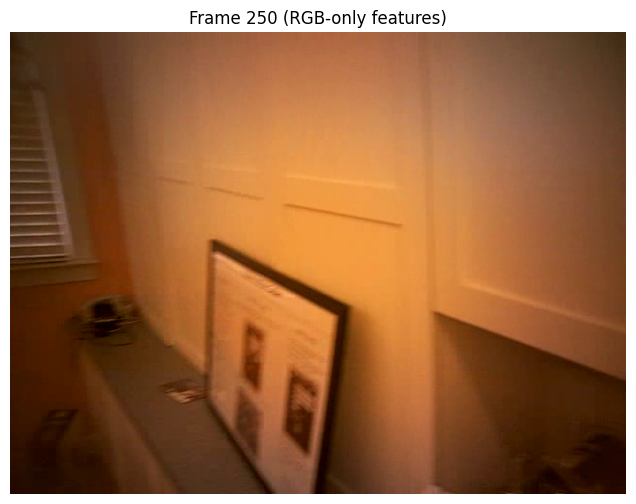

In [28]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

VIDEO_PATH = Path(r"D:\Datasets\Datasets\EGTEA+\Video\OP01-R05-Cheeseburger.mp4")
NPZ_PATH   = Path(r"D:\Datasets\Datasets\EGTEA+\Features\OP01-R05-Cheeseburger_RGB_npz\frame_000250.npz")

data = np.load(NPZ_PATH)
visual_feat = data["visual_feat"]

print("Visual feat shape:", visual_feat.shape)

frame_idx = int(NPZ_PATH.stem.split("_")[1])
print("Frame index:", frame_idx)

cap = cv2.VideoCapture(str(VIDEO_PATH))
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Could not read frame from video")

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,6))
plt.imshow(frame_rgb)
plt.axis("off")
plt.title(f"Frame {frame_idx} (RGB-only features)")
plt.show()


## SECTION 3: DATASET LOADER (SINGLE & MULTI VIDEO) 

In [29]:
# ========= ==============
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

IGNORE_INDEX = -1

def _detect_feat_cols_from_fused_df(fused_df: pd.DataFrame, expected_dim: int | None = None):
    """
    Detect feature columns from fused_df.
    Priority:
      1) columns starting with 'fused_'
      2) columns starting with 'feat_'
    Columns are sorted by the integer suffix.
    """
    feat_cols = []
    for prefix in ["fused_", "feat_"]:
        cand = [c for c in fused_df.columns if c.startswith(prefix)]
        if cand:
            # sort by numeric suffix
            def _idx(name):
                try:
                    return int(name.split("_")[1])
                except Exception:
                    return 1e9
            feat_cols = sorted(cand, key=_idx)
            break

    if not feat_cols:
        raise RuntimeError(
            f"Could not detect feature columns in fused_df. "
            f"Expected columns like 'fused_0' or 'feat_0'. "
            f"Got columns: {list(fused_df.columns)[:20]} ..."
        )

    if expected_dim is not None and expected_dim > 0 and len(feat_cols) != expected_dim:
        print(
            f"[WARN] Detected {len(feat_cols)} feature columns, "
            f"but feat_dim={expected_dim}. Using detected columns."
        )

    return feat_cols


class SingleVideoAnticipationDataset(Dataset):
    def __init__(self, fused_df_or_path,
                 labels_df_or_path,
                 t_obs: int,
                 k_fut: int,
                 feat_dim: int,
                 fps: float,
                 horizons_s: list[float]):
        # ----- load fused_df -----
        if isinstance(fused_df_or_path, (str, Path)):
            fused_df = pd.read_csv(fused_df_or_path)
        else:
            fused_df = fused_df_or_path.copy()

        # ----- load labels_df -----
        if isinstance(labels_df_or_path, (str, Path)):
            labels_df = pd.read_csv(labels_df_or_path)
        else:
            labels_df = labels_df_or_path.copy()

        if "frame_index" not in fused_df.columns:
            raise KeyError("fused_df must contain 'frame_index'")

        fused_df["frame_index"] = fused_df["frame_index"].astype(int)
        fused_df = fused_df.set_index("frame_index", drop=False).sort_index()

        self.fused_df = fused_df
        self.labels_df = labels_df.reset_index(drop=True)

        if not all(c in self.labels_df.columns for c in ["StartFrame", "EndFrame"]):
            raise KeyError("labels_df must contain StartFrame and EndFrame")

        self.t_obs = int(t_obs)
        self.k_fut = int(k_fut)

        # ---- detect feature columns automatically ----
        self.feat_cols = _detect_feat_cols_from_fused_df(fused_df, expected_dim=feat_dim)
        self.feat_dim = len(self.feat_cols)

        # ---- time info ----
        self.fps = float(fps)
        assert len(horizons_s) == self.k_fut, "len(horizons_s) must equal k_fut"
        self.horizons_s = list(horizons_s)

        # ---- build samples: one per label row ----
        self.samples = []
        for ridx, row in self.labels_df.iterrows():
            try:
                obs_end = int(row["EndFrame"])
            except Exception:
                continue
            self.samples.append({"label_row_idx": int(ridx), "obs_end": obs_end})

        if len(self.samples) == 0:
            raise RuntimeError("No valid label rows found")

    def __len__(self):
        return len(self.samples)

    # === time-based future labels ===
    def _time_based_future_labels(self, obs_end: int):
        """
        For each horizon t in self.horizons_s (seconds),
        compute future_frame = obs_end + round(t * fps),
        then find which action segment covers that frame.
        """
        labels_df = self.labels_df

        def pick(cols):
            for c in cols:
                if c in labels_df.columns:
                    return c
            return None

        vcol = pick(["Verb_class", "verb", "Verb", "verb_class"])
        ncol = pick(["Noun_class", "noun", "Noun", "noun_class"])
        acol = pick(["Action_class", "action", "Action", "ActionLabel"])

        verb_targets   = []
        noun_targets   = []
        action_targets = []

        for h_sec in self.horizons_s:
            future_frame = obs_end + int(round(h_sec * self.fps))
            seg = labels_df[
                (labels_df["StartFrame"] <= future_frame) &
                (labels_df["EndFrame"]   >= future_frame)
            ]
            if seg.empty:
                verb_targets.append(IGNORE_INDEX)
                noun_targets.append(IGNORE_INDEX)
                action_targets.append(IGNORE_INDEX)
            else:
                row = seg.iloc[0]
                if vcol is not None and not pd.isna(row[vcol]):
                    verb_targets.append(int(row[vcol]))
                else:
                    verb_targets.append(IGNORE_INDEX)

                if ncol is not None and not pd.isna(row[ncol]):
                    noun_targets.append(int(row[ncol]))
                else:
                    noun_targets.append(IGNORE_INDEX)

                if acol is not None and not pd.isna(row[acol]):
                    action_targets.append(int(row[acol]))
                else:
                    action_targets.append(IGNORE_INDEX)

        return {
            "verb":   torch.LongTensor(verb_targets),
            "noun":   torch.LongTensor(noun_targets),
            "action": torch.LongTensor(action_targets),
        }

    def __getitem__(self, idx):
        rec = self.samples[idx]
        obs_end = rec["obs_end"]

        # observation window [obs_start, obs_end]
        obs_start = obs_end - (self.t_obs - 1)
        if obs_start < 0:
            obs_start = 0
            obs_end = obs_start + (self.t_obs - 1)

        fused_idx_min = int(self.fused_df.index.min())
        fused_idx_max = int(self.fused_df.index.max())

        obs_end = min(obs_end, fused_idx_max)
        obs_start = max(obs_end - (self.t_obs - 1), fused_idx_min)

        desired = list(range(obs_start, obs_end + 1))

        # reindex, fill missing frames by ffill/bfill then 0
        sel = self.fused_df.reindex(desired).fillna(method="ffill").fillna(method="bfill").fillna(0.0)

        # ensure we have exactly t_obs frames (pad if needed)
        if sel.shape[0] < self.t_obs:
            if sel.shape[0] == 0:
                zero_row = {c: 0.0 for c in self.feat_cols}
                sel = pd.DataFrame([zero_row] * self.t_obs)
            else:
                first = sel.iloc[[0]]
                pads = pd.concat([first] * (self.t_obs - sel.shape[0]), ignore_index=True)
                sel = pd.concat([pads, sel.reset_index(drop=True)], ignore_index=True)

        # just take the feature matrix:
        F_window = torch.from_numpy(sel[self.feat_cols].to_numpy(dtype=np.float32))  # (T_obs, feat_dim)

        y_multi = self._time_based_future_labels(obs_end)

        meta = {
            "obs_start": int(obs_start),
            "obs_end":   int(obs_end),
            "label_row_idx": int(rec["label_row_idx"]),
        }
        return F_window, y_multi, meta


class MultiVideoAnticipationDataset(Dataset):
    """
    Accepts explicit lists: fused_csv_paths (list of paths) and label_csv_paths (same-length list).
    Builds samples across videos. Assumes all fused CSVs share the same feature column naming.
    """
    def __init__(self,
                 fused_csv_paths: list[str | Path],
                 label_csv_paths: list[str | Path],
                 t_obs: int,
                 k_fut: int,
                 feat_dim: int):

        assert len(fused_csv_paths) == len(label_csv_paths), "Provide matching lists of fused and label CSVs"

        self.t_obs = int(t_obs)
        self.k_fut = int(k_fut)

        self.samples = []
        self.feat_cols = None
        self.feat_dim = None

        for vid_idx, (fpath, lpath) in enumerate(zip(fused_csv_paths, label_csv_paths)):
            fused_df = pd.read_csv(fpath)
            labels_df = pd.read_csv(lpath)

            if "frame_index" not in fused_df.columns:
                raise KeyError(f"'frame_index' missing in fused CSV: {fpath}")

            fused_df["frame_index"] = fused_df["frame_index"].astype(int)
            fused_df = fused_df.set_index("frame_index", drop=False).sort_index()

            # detect features for the first video, then enforce consistency
            if self.feat_cols is None:
                self.feat_cols = _detect_feat_cols_from_fused_df(fused_df, expected_dim=feat_dim)
                self.feat_dim = len(self.feat_cols)
            else:
                missing = [c for c in self.feat_cols if c not in fused_df.columns]
                if missing:
                    raise RuntimeError(
                        f"Fused CSV {fpath} is missing expected feature columns: {missing[:10]} ..."
                    )

            labels_df = labels_df.reset_index(drop=True)
            for ridx, row in labels_df.iterrows():
                try:
                    obs_end = int(row["EndFrame"])
                except Exception:
                    continue
                self.samples.append({
                    "fused_df": fused_df,
                    "labels_df": labels_df,
                    "vid_idx": vid_idx,
                    "label_row_idx": int(ridx),
                    "obs_end": int(obs_end),
                })

        if len(self.samples) == 0:
            raise RuntimeError("No samples found across the provided fused/label CSVs")

    def __len__(self):
        return len(self.samples)

    def _future_labels(self, labels_df: pd.DataFrame, obs_end: int):
        fut = labels_df[labels_df["StartFrame"] > obs_end].sort_values("StartFrame")

        def pick(cols):
            for c in cols:
                if c in labels_df.columns:
                    return c
            return None

        vcol = pick(["Verb_class", "verb", "Verb", "verb_class"])
        ncol = pick(["Noun_class", "noun", "Noun", "noun_class"])
        acol = pick(["Action_class", "action", "Action", "ActionLabel"])

        def collect(col_name):
            if col_name is None:
                return [IGNORE_INDEX] * self.k_fut
            vals = fut[col_name].tolist()[:self.k_fut]
            while len(vals) < self.k_fut:
                vals.append(IGNORE_INDEX)
            return [int(x) if not pd.isna(x) else IGNORE_INDEX for x in vals]

        return {
            "verb":   torch.LongTensor(collect(vcol)),
            "noun":   torch.LongTensor(collect(ncol)),
            "action": torch.LongTensor(collect(acol)),
        }

    def __getitem__(self, idx):
        rec = self.samples[idx]
        fused_df = rec["fused_df"]
        labels_df = rec["labels_df"]
        obs_end = rec["obs_end"]

        obs_start = obs_end - (self.t_obs - 1)
        if obs_start < 0:
            obs_start = 0
            obs_end = obs_start + (self.t_obs - 1)

        fused_idx_min = int(fused_df.index.min())
        fused_idx_max = int(fused_df.index.max())
        obs_end = min(obs_end, fused_idx_max)
        obs_start = max(obs_end - (self.t_obs - 1), fused_idx_min)

        desired = list(range(obs_start, obs_end + 1))
        sel = fused_df.reindex(desired).fillna(method="ffill").fillna(method="bfill").fillna(0.0)

        if sel.shape[0] < self.t_obs:
            if sel.shape[0] == 0:
                zero_row = {c: 0.0 for c in self.feat_cols}
                sel = pd.DataFrame([zero_row] * self.t_obs)
            else:
                first = sel.iloc[[0]]
                pads = pd.concat([first] * (self.t_obs - sel.shape[0]), ignore_index=True)
                sel = pd.concat([pads, sel.reset_index(drop=True)], ignore_index=True)

        F_window = torch.from_numpy(sel[self.feat_cols].to_numpy(dtype=np.float32))  # (T_obs, feat_dim)
        y_multi = self._future_labels(labels_df, obs_end)
        meta = {
            "obs_start": int(obs_start),
            "obs_end":   int(obs_end),
            "vid_idx":   int(rec["vid_idx"]),
            "label_row_idx": int(rec["label_row_idx"]),
        }
        return F_window, y_multi, meta


## SECTION 4: MODEL, LOSS, METRICS 

In [30]:
# ========= =================
K = 3  # KNN graph
DROP = 0.1

def build_topk_edge_index(features: torch.Tensor, k=K):
    """
    features: (T, D) torch tensor
    returns edge_index: (2, E) long tensor (undirected duplicated edges)
    """
    Tn = int(features.size(0))
    x = F.normalize(features, dim=1)
    sim = torch.matmul(x, x.t())   # (T,T)
    sim.fill_diagonal_(-1.0)
    vals, idxs = torch.topk(sim, k, dim=1)
    src = torch.arange(Tn).unsqueeze(1).expand(-1, k).reshape(-1)
    dst = idxs.reshape(-1)
    edge = torch.stack([src, dst], dim=0)
    edge_rev = torch.stack([dst, src], dim=0)
    return torch.cat([edge, edge_rev], dim=1).long()

class BatchedGAT(nn.Module):
    def __init__(self, in_dim, hid_dim=None, num_layers=3, heads=8, dropout=DROP):
        super().__init__()
        hid = hid_dim or in_dim
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            in_ch = in_dim if i==0 else hid
            self.convs.append(GATConv(in_ch, hid//heads, heads=heads, concat=True, dropout=dropout))
        self.proj = nn.Linear(hid, in_dim)
        self.norm = nn.LayerNorm(in_dim)
        self.act = nn.GELU()
    def forward(self, pyg_batch: PyGBatch, T_per_sample: int):
        x = pyg_batch.x; edge_index = pyg_batch.edge_index
        h = x
        for conv in self.convs:
            h = conv(h, edge_index); h = self.act(h)
        h = self.proj(h)
        node_feats, mask = to_dense_batch(h, batch=pyg_batch.batch)  # (B, max_nodes, D)
        B, max_nodes, D = node_feats.shape
        if max_nodes < T_per_sample:
            pad = torch.zeros(B, T_per_sample - max_nodes, D, device=node_feats.device)
            node_feats = torch.cat([node_feats, pad], dim=1)
        elif max_nodes > T_per_sample:
            node_feats = node_feats[:, :T_per_sample, :]
        return self.norm(node_feats)  # (B, T_per_sample, D)

class SimpleTransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead=8, num_layers=3, dim_feedforward=2048, dropout=DROP, max_len=1000):
        super().__init__()
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            activation='gelu', batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc, num_layers=num_layers)
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, d_model))
    def forward(self, x):
        B,T,D = x.shape
        pos = self.pos_emb[:, :T, :].to(x.device)
        return self.encoder(x + pos)

class AnticipationModel(nn.Module):
    def __init__(self, feat_dim, num_classes: dict,
                 k_fut=5, gat_layers=3, gat_heads=8,
                 dec_layers=3, dec_heads=8, dropout=DROP):
        super().__init__()
        self.feat_dim = feat_dim; self.k_fut = k_fut
        self.gat = BatchedGAT(in_dim=feat_dim, hid_dim=feat_dim,
                              num_layers=gat_layers, heads=gat_heads,
                              dropout=dropout)
        self.encoder = SimpleTransformerEncoder(d_model=feat_dim, nhead=dec_heads, num_layers=3)
        dec_layer = nn.TransformerDecoderLayer(
            d_model=feat_dim, nhead=dec_heads,
            dim_feedforward=feat_dim*4, dropout=dropout,
            activation='gelu', batch_first=True
        )
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=dec_layers)
        self.queries = nn.Parameter(torch.randn(1, k_fut, feat_dim))
        assert isinstance(num_classes, dict)
        self.verb_head   = nn.Linear(feat_dim, num_classes["verb"])
        self.noun_head   = nn.Linear(feat_dim, num_classes["noun"])
        self.action_head = nn.Linear(feat_dim, num_classes["action"])

    def forward(self, F_batch):
        # F_batch: (B, T, D)
        B,T,D = F_batch.shape
        device = F_batch.device
        data_list=[]
        for b in range(B):
            x = F_batch[b]
            edge_index = build_topk_edge_index(x.detach().cpu(), k=K).to(device)
            data_list.append(PyGData(x=x, edge_index=edge_index))
        pyg_batch = PyGBatch.from_data_list(data_list).to(device)
        G = self.gat(pyg_batch, T_per_sample=T)   # (B,T,D)
        H = self.encoder(F_batch)                 # (B,T,D)
        U = H + G
        q = self.queries.expand(B, -1, -1).to(device)
        dec_out = self.decoder(tgt=q, memory=U)   # (B, K_fut, D)
        return {
            "verb":   self.verb_head(dec_out),
            "noun":   self.noun_head(dec_out),
            "action": self.action_head(dec_out)
        }

import torch.nn.functional as F

def masked_cross_entropy(logits, labels, ignore_index=IGNORE_INDEX):
    B,K,C = logits.shape
    logits_flat = logits.view(B*K, C)
    labels_flat = labels.view(B*K)
    loss_flat = F.cross_entropy(logits_flat, labels_flat, reduction='none', ignore_index=ignore_index)
    mask = (labels_flat != ignore_index).float()
    valid = mask.sum()

    if valid == 0:
        # zero scalar connected to logits, gradient = 0, but backward() is valid
        return (logits_flat * 0.0).sum()

    return (loss_flat * mask).sum() / valid


def topk_accuracy_per_task(logits, labels, topk=(1,5), ignore_index=IGNORE_INDEX):
    """
    logits: (B,K,C), labels: (B,K)
    returns dict with 'per_h{h}_top{k}' and 'overall_top{k}'
    """
    B,K,C = logits.shape
    res = {}
    overall = {k:0 for k in topk}
    total_cnt = 0
    preds_topk = logits.topk(max(topk), dim=-1)[1]  # (B,K,maxk)
    for h in range(K):
        lab = labels[:,h]; mask = (lab != ignore_index); cnt = int(mask.sum().item())
        for k in topk:
            if cnt == 0:
                res.setdefault(f"per_h{h+1}_top{k}", None)
                continue
            predk = preds_topk[:,h,:k]  # (B,k)
            lab_exp = lab.unsqueeze(1).expand(-1, k)
            hits = (predk == lab_exp)
            hit = int(hits[mask].any(dim=1).float().sum().item())
            res[f"per_h{h+1}_top{k}"] = hit / cnt
            overall[k] += hit
        total_cnt += cnt
    for k in topk:
        res[f"overall_top{k}"] = overall[k] / total_cnt if total_cnt>0 else None
    return res

## SECTION 5: TRAINING / EVALUATION

In [31]:
# ========= CONGIG. =================

FUSED_CSV_PATH = r"D:\Datasets\Datasets\EGTEA+\Features\OP01-R05-Cheeseburger_RGB.csv"
LABEL_CSV_PATH = r"D:\Datasets\Datasets\EGTEA+\Labels\OP01-R05-Cheeseburger_Label.csv"
BEST_MODEL_PATH = Path(r"D:\Datasets\Datasets\EGTEA+\Model\OP01-R05-Cheeseburger_RGBOnly_model.pth")

# Hyperparams
T_OBS = 90
FEAT_DIM = 512
BATCH_SIZE = 8
NUM_EPOCHS = 30
LR = 1e-5
WD = 5e-4
NUM_WORKERS = 0

# === Time-based anticipation config ===
FPS = 30.0  # <-- set this correctly for your EGTEA videos
HORIZONS_S = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]   # seconds into the future
K_FUT = len(HORIZONS_S)               # model will output one label per horizon

# ================  =====================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def detect_num_classes_from_labels_df(labels_df):
    verbs=set(); nouns=set(); actions=set()
    for cand in ["Verb_class","verb","Verb","verb_class"]:
        if cand in labels_df.columns:
            verbs.update(labels_df[cand].dropna().astype(int).tolist()); break
    for cand in ["Noun_class","noun","Noun","noun_class"]:
        if cand in labels_df.columns:
            nouns.update(labels_df[cand].dropna().astype(int).tolist()); break
    for cand in ["Action_class","action","Action","ActionLabel"]:
        if cand in labels_df.columns:
            actions.update(labels_df[cand].dropna().astype(int).tolist()); break
    nv = (max(verbs) + 1) if len(verbs)>0 else 1
    nn_ = (max(nouns) + 1) if len(nouns)>0 else 1
    na = (max(actions) + 1) if len(actions)>0 else 1
    return {"verb": int(nv), "noun": int(nn_), "action": int(na)}

def topk_counts(logits, labels, k):
    # logits: (B, K_fut, C); labels: (B, K_fut)
    with torch.no_grad():
        B,K,C = logits.shape
        topk_preds = logits.topk(k, dim=-1)[1]  # (B, K, k)
        hits = 0
        total = 0
        for h in range(K):
            lab = labels[:, h]            # (B,)
            mask = (lab != -1)
            if int(mask.sum().item()) == 0:
                continue
            predk = topk_preds[:, h, :]   # (B, k)
            lab_exp = lab.unsqueeze(1).expand(-1, k)
            masked_pred = predk[mask]     # (M,k)
            masked_lab = lab_exp[mask]    # (M,k)
            hit_vec = (masked_pred == masked_lab).any(dim=1).float()
            hits += int(hit_vec.sum().item())
            total += int(mask.sum().item())
        return hits, total

# Load RGB features and labels
fused_df = pd.read_csv(FUSED_CSV_PATH)
labels_df = pd.read_csv(LABEL_CSV_PATH)

# Dataset 
dataset = SingleVideoAnticipationDataset(
    fused_df,
    labels_df,
    t_obs=T_OBS,
    k_fut=K_FUT,        # must equal len(HORIZONS_S)
    feat_dim=FEAT_DIM,
    fps=FPS,
    horizons_s=HORIZONS_S
)

# split indices for train/val (60/40)
indices = list(range(len(dataset)))
random.seed(42)
random.shuffle(indices)
split_at = int(0.6 * len(indices))
train_idx = indices[:split_at]
val_idx   = indices[split_at:]

train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))

# detect number of classes and instantiate model
num_classes = detect_num_classes_from_labels_df(labels_df)
print("Detected num_classes:", num_classes)
model = AnticipationModel(feat_dim=FEAT_DIM, num_classes=num_classes, k_fut=K_FUT).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)

best_val_loss = float("inf")

for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- TRAIN -------------
    model.train()
    train_loss_sum = 0.0
    train_samples = 0
    train_counts = {
        "verb_top1": [0, 0], "verb_top5": [0, 0],
        "noun_top1": [0, 0], "noun_top5": [0, 0],
        "action_top1": [0, 0], "action_top5": [0, 0]
    }

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} Train", leave=False)
    for F_batch, y_multi, meta in pbar:
        F_batch = F_batch.to(DEVICE)               # (B, T, D)
        y_v = y_multi["verb"].to(DEVICE)           # (B, K_fut)
        y_n = y_multi["noun"].to(DEVICE)
        y_a = y_multi["action"].to(DEVICE)

        opt.zero_grad()
        logits = model(F_batch)   # dict: "verb"/"noun"/"action" -> (B,K_fut,C)

        loss_v = masked_cross_entropy(logits["verb"], y_v)
        loss_n = masked_cross_entropy(logits["noun"], y_n)
        loss_a = masked_cross_entropy(logits["action"], y_a)
        loss = loss_a + 0.5 * loss_v + 0.5 * loss_n

        loss.backward()
        opt.step()

        b = F_batch.size(0)
        train_loss_sum += float(loss.item()) * b
        train_samples += b

        for (task, lab, lg) in [
            ("verb", y_v, logits["verb"]),
            ("noun", y_n, logits["noun"]),
            ("action", y_a, logits["action"])
        ]:
            h1, t1 = topk_counts(lg.detach().cpu(), lab.detach().cpu(), k=1)
            h5, t5 = topk_counts(lg.detach().cpu(), lab.detach().cpu(), k=5)
            train_counts[f"{task}_top1"][0] += h1
            train_counts[f"{task}_top1"][1] += t1
            train_counts[f"{task}_top5"][0] += h5
            train_counts[f"{task}_top5"][1] += t5

    train_loss = train_loss_sum / max(1, train_samples)
    train_metrics = {}
    for task in ["verb", "noun", "action"]:
        h1, t1 = train_counts[f"{task}_top1"]
        h5, t5 = train_counts[f"{task}_top5"]
        train_metrics[f"{task}_top1"] = (h1 / t1) if t1 > 0 else None
        train_metrics[f"{task}_top5"] = (h5 / t5) if t5 > 0 else None

    # ------------- VALIDATION -------------
    model.eval()
    val_loss_sum = 0.0
    val_samples = 0
    val_counts = {
        "verb_top1": [0, 0], "verb_top5": [0, 0],
        "noun_top1": [0, 0], "noun_top5": [0, 0],
        "action_top1": [0, 0], "action_top5": [0, 0]
    }

    # store logits/labels for per-horizon metrics
    val_logits_store = {"verb": [], "noun": [], "action": []}
    val_labels_store = {"verb": [], "noun": [], "action": []}

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch} Val", leave=False)
        for F_batch, y_multi, meta in pbar:
            F_batch = F_batch.to(DEVICE)
            y_v = y_multi["verb"].to(DEVICE)
            y_n = y_multi["noun"].to(DEVICE)
            y_a = y_multi["action"].to(DEVICE)

            logits = model(F_batch)
            loss_v = masked_cross_entropy(logits["verb"], y_v)
            loss_n = masked_cross_entropy(logits["noun"], y_n)
            loss_a = masked_cross_entropy(logits["action"], y_a)
            loss = loss_a + 0.5 * loss_v + 0.5 * loss_n

            b = F_batch.size(0)
            val_loss_sum += float(loss.item()) * b
            val_samples += b

            for (task, lab, lg) in [
                ("verb", y_v, logits["verb"]),
                ("noun", y_n, logits["noun"]),
                ("action", y_a, logits["action"])
            ]:
                h1, t1 = topk_counts(lg.detach().cpu(), lab.detach().cpu(), k=1)
                h5, t5 = topk_counts(lg.detach().cpu(), lab.detach().cpu(), k=5)
                val_counts[f"{task}_top1"][0] += h1
                val_counts[f"{task}_top1"][1] += t1
                val_counts[f"{task}_top5"][0] += h5
                val_counts[f"{task}_top5"][1] += t5

            # store for per-horizon metrics
            val_logits_store["verb"].append(logits["verb"].detach().cpu())
            val_logits_store["noun"].append(logits["noun"].detach().cpu())
            val_logits_store["action"].append(logits["action"].detach().cpu())
            val_labels_store["verb"].append(y_v.detach().cpu())
            val_labels_store["noun"].append(y_n.detach().cpu())
            val_labels_store["action"].append(y_a.detach().cpu())

    val_loss = val_loss_sum / max(1, val_samples)

    # overall val metrics (top-1/top-5 over all horizons)
    val_metrics = {}
    for task in ["verb", "noun", "action"]:
        h1, t1 = val_counts[f"{task}_top1"]
        h5, t5 = val_counts[f"{task}_top5"]
        val_metrics[f"{task}_top1"] = (h1 / t1) if t1 > 0 else None
        val_metrics[f"{task}_top5"] = (h5 / t5) if t5 > 0 else None

    # per-horizon metrics (time-based)
    per_horizon_metrics = {"verb": {}, "noun": {}, "action": {}}
    for task in ["verb", "noun", "action"]:
        if len(val_logits_store[task]) == 0:
            continue
        logits_all = torch.cat(val_logits_store[task], dim=0)  # (N, K_fut, C)
        labels_all = torch.cat(val_labels_store[task], dim=0)  # (N, K_fut)
        m = topk_accuracy_per_task(logits_all, labels_all,
                                   topk=(1, 5), ignore_index=IGNORE_INDEX)
        per_horizon_metrics[task] = m

    # scheduler + logging
    sched.step(val_loss)
    elapsed = time.time() - t0

    print(f"Epoch {epoch}/{NUM_EPOCHS} | Time {elapsed:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    for task in ["verb", "noun", "action"]:
        print(f"  {task.upper():6s} Train Top1: {train_metrics[f'{task}_top1']}, "
              f"Top5: {train_metrics[f'{task}_top5']}; "
              f"Val Top1: {val_metrics[f'{task}_top1']}, "
              f"Top5: {val_metrics[f'{task}_top5']}")

    # print per-horizon by seconds
    for task in ["verb", "noun", "action"]:
        mh = per_horizon_metrics[task]
        if not mh:
            continue
        print(f"  {task.upper():6s} per-horizon (time-based):")
        for h_idx, t_sec in enumerate(HORIZONS_S):
            key1 = f"per_h{h_idx+1}_top1"
            key5 = f"per_h{h_idx+1}_top5"
            v1 = mh.get(key1, None)
            v5 = mh.get(key5, None)
            print(f"    @ {t_sec:4.2f}s  Top1: {v1}  Top5: {v5}")
        print(f"    overall_top1: {mh.get('overall_top1', None)}, "
              f"overall_top5: {mh.get('overall_top5', None)}")

    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'opt_state': opt.state_dict(),
            'val_loss': val_loss
        }, BEST_MODEL_PATH)
        print(f"[SAVED BEST] -> {BEST_MODEL_PATH}")

print("Training finished.")

Detected num_classes: {'verb': 107, 'noun': 38, 'action': 51}


Epoch 1 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/30 | Time 4.5s
  Train Loss: 7.3876 | Val Loss: 6.7008
  VERB   Train Top1: 0.012802275960170697, Top5: 0.03698435277382646; Val Top1: 0.03219315895372234, Top5: 0.07243460764587525
  NOUN   Train Top1: 0.21763869132290184, Top5: 0.5974395448079659; Val Top1: 0.2515090543259557, Top5: 0.7525150905432596
  ACTION Train Top1: 0.16927453769559034, Top5: 0.41536273115220484; Val Top1: 0.1750503018108652, Top5: 0.5492957746478874
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.017857142857142856  Top5: 0.07142857142857142
    @ 0.50s  Top1: 0.05  Top5: 0.05
    @ 0.75s  Top1: 0.046875  Top5: 0.0625
    @ 1.00s  Top1: 0.045454545454545456  Top5: 0.07575757575757576
    @ 1.25s  Top1: 0.0  Top5: 0.0967741935483871
    @ 1.50s  Top1: 0.01639344262295082  Top5: 0.08196721311475409
    @ 1.75s  Top1: 0.046875  Top5: 0.09375
    @ 2.00s  Top1: 0.03125  Top5: 0.046875
    overall_top1: 0.03219315895372234, overall_top5: 0.07243460764587525
  NOUN   per-horizon (time-based):
    @ 0

Epoch 2 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/30 | Time 4.3s
  Train Loss: 6.1163 | Val Loss: 5.9810
  VERB   Train Top1: 0.12375533428165007, Top5: 0.2574679943100996; Val Top1: 0.17706237424547283, Top5: 0.30181086519114686
  NOUN   Train Top1: 0.2702702702702703, Top5: 0.8349928876244666; Val Top1: 0.30985915492957744, Top5: 0.8309859154929577
  ACTION Train Top1: 0.30440967283072545, Top5: 0.6657183499288762; Val Top1: 0.26961770623742454, Top5: 0.6659959758551308
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.21428571428571427  Top5: 0.30357142857142855
    @ 0.50s  Top1: 0.18333333333333332  Top5: 0.2833333333333333
    @ 0.75s  Top1: 0.171875  Top5: 0.296875
    @ 1.00s  Top1: 0.16666666666666666  Top5: 0.2878787878787879
    @ 1.25s  Top1: 0.14516129032258066  Top5: 0.2903225806451613
    @ 1.50s  Top1: 0.16393442622950818  Top5: 0.32786885245901637
    @ 1.75s  Top1: 0.1875  Top5: 0.328125
    @ 2.00s  Top1: 0.1875  Top5: 0.296875
    overall_top1: 0.17706237424547283, overall_top5: 0.30181086519114686
  

Epoch 3 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/30 | Time 4.2s
  Train Loss: 5.4507 | Val Loss: 5.5454
  VERB   Train Top1: 0.20625889046941678, Top5: 0.4423897581792319; Val Top1: 0.15694164989939638, Top5: 0.42052313883299797
  NOUN   Train Top1: 0.3129445234708393, Top5: 0.8662873399715505; Val Top1: 0.3782696177062374, Top5: 0.8490945674044266
  ACTION Train Top1: 0.406827880512091, Top5: 0.7553342816500711; Val Top1: 0.2796780684104628, Top5: 0.7062374245472837
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.19642857142857142  Top5: 0.39285714285714285
    @ 0.50s  Top1: 0.18333333333333332  Top5: 0.4
    @ 0.75s  Top1: 0.125  Top5: 0.4375
    @ 1.00s  Top1: 0.16666666666666666  Top5: 0.42424242424242425
    @ 1.25s  Top1: 0.12903225806451613  Top5: 0.3870967741935484
    @ 1.50s  Top1: 0.13114754098360656  Top5: 0.4426229508196721
    @ 1.75s  Top1: 0.1875  Top5: 0.453125
    @ 2.00s  Top1: 0.140625  Top5: 0.421875
    overall_top1: 0.15694164989939638, overall_top5: 0.42052313883299797
  NOUN   per-horizon (ti

Epoch 4 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/30 | Time 4.3s
  Train Loss: 4.9000 | Val Loss: 5.1522
  VERB   Train Top1: 0.25177809388335703, Top5: 0.5391180654338549; Val Top1: 0.2454728370221328, Top5: 0.4607645875251509
  NOUN   Train Top1: 0.3869132290184922, Top5: 0.8762446657183499; Val Top1: 0.4346076458752515, Top5: 0.8772635814889336
  ACTION Train Top1: 0.46799431009957326, Top5: 0.8392603129445235; Val Top1: 0.34004024144869216, Top5: 0.806841046277666
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.19642857142857142  Top5: 0.42857142857142855
    @ 0.50s  Top1: 0.23333333333333334  Top5: 0.43333333333333335
    @ 0.75s  Top1: 0.21875  Top5: 0.5
    @ 1.00s  Top1: 0.2727272727272727  Top5: 0.5
    @ 1.25s  Top1: 0.3064516129032258  Top5: 0.45161290322580644
    @ 1.50s  Top1: 0.26229508196721313  Top5: 0.4426229508196721
    @ 1.75s  Top1: 0.21875  Top5: 0.4375
    @ 2.00s  Top1: 0.25  Top5: 0.484375
    overall_top1: 0.2454728370221328, overall_top5: 0.4607645875251509
  NOUN   per-horizon (time-based)

Epoch 5 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/30 | Time 4.2s
  Train Loss: 4.4495 | Val Loss: 4.8549
  VERB   Train Top1: 0.3015647226173542, Top5: 0.5903271692745377; Val Top1: 0.26156941649899396, Top5: 0.48088531187122735
  NOUN   Train Top1: 0.41963015647226176, Top5: 0.9160739687055477; Val Top1: 0.44064386317907445, Top5: 0.9195171026156942
  ACTION Train Top1: 0.5547652916073968, Top5: 0.8947368421052632; Val Top1: 0.3641851106639839, Top5: 0.8792756539235412
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.19642857142857142  Top5: 0.42857142857142855
    @ 0.50s  Top1: 0.25  Top5: 0.45
    @ 0.75s  Top1: 0.265625  Top5: 0.5
    @ 1.00s  Top1: 0.2727272727272727  Top5: 0.5
    @ 1.25s  Top1: 0.3225806451612903  Top5: 0.45161290322580644
    @ 1.50s  Top1: 0.26229508196721313  Top5: 0.47540983606557374
    @ 1.75s  Top1: 0.25  Top5: 0.5
    @ 2.00s  Top1: 0.265625  Top5: 0.53125
    overall_top1: 0.26156941649899396, overall_top5: 0.48088531187122735
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.4464

Epoch 6 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/30 | Time 4.3s
  Train Loss: 4.1380 | Val Loss: 4.5407
  VERB   Train Top1: 0.35704125177809387, Top5: 0.6642958748221907; Val Top1: 0.2977867203219316, Top5: 0.5271629778672032
  NOUN   Train Top1: 0.4623044096728307, Top5: 0.9445234708392604; Val Top1: 0.44668008048289737, Top5: 0.9456740442655935
  ACTION Train Top1: 0.577524893314367, Top5: 0.9345661450924608; Val Top1: 0.43259557344064387, Top5: 0.9134808853118712
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.21428571428571427  Top5: 0.4642857142857143
    @ 0.50s  Top1: 0.25  Top5: 0.5166666666666667
    @ 0.75s  Top1: 0.328125  Top5: 0.578125
    @ 1.00s  Top1: 0.3181818181818182  Top5: 0.5606060606060606
    @ 1.25s  Top1: 0.3225806451612903  Top5: 0.46774193548387094
    @ 1.50s  Top1: 0.29508196721311475  Top5: 0.5245901639344263
    @ 1.75s  Top1: 0.28125  Top5: 0.53125
    @ 2.00s  Top1: 0.359375  Top5: 0.5625
    overall_top1: 0.2977867203219316, overall_top5: 0.5271629778672032
  NOUN   per-horizon (time

Epoch 7 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/30 | Time 4.3s
  Train Loss: 3.7587 | Val Loss: 4.2985
  VERB   Train Top1: 0.41536273115220484, Top5: 0.7297297297297297; Val Top1: 0.30985915492957744, Top5: 0.6036217303822937
  NOUN   Train Top1: 0.4822190611664296, Top5: 0.968705547652916; Val Top1: 0.47484909456740443, Top5: 0.9637826961770624
  ACTION Train Top1: 0.6273115220483642, Top5: 0.9672830725462305; Val Top1: 0.5110663983903421, Top5: 0.9275653923541247
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.21428571428571427  Top5: 0.625
    @ 0.50s  Top1: 0.26666666666666666  Top5: 0.6666666666666666
    @ 0.75s  Top1: 0.328125  Top5: 0.6875
    @ 1.00s  Top1: 0.3181818181818182  Top5: 0.6363636363636364
    @ 1.25s  Top1: 0.3387096774193548  Top5: 0.5483870967741935
    @ 1.50s  Top1: 0.3442622950819672  Top5: 0.5245901639344263
    @ 1.75s  Top1: 0.296875  Top5: 0.578125
    @ 2.00s  Top1: 0.359375  Top5: 0.5625
    overall_top1: 0.30985915492957744, overall_top5: 0.6036217303822937
  NOUN   per-horizon (tim

Epoch 8 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/30 | Time 4.3s
  Train Loss: 3.4142 | Val Loss: 4.0596
  VERB   Train Top1: 0.44523470839260315, Top5: 0.7724039829302988; Val Top1: 0.30985915492957744, Top5: 0.6780684104627767
  NOUN   Train Top1: 0.55049786628734, Top5: 0.9786628733997155; Val Top1: 0.5010060362173038, Top5: 0.9637826961770624
  ACTION Train Top1: 0.6714082503556188, Top5: 0.9829302987197724; Val Top1: 0.49295774647887325, Top5: 0.9255533199195171
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.26785714285714285  Top5: 0.7321428571428571
    @ 0.50s  Top1: 0.3  Top5: 0.75
    @ 0.75s  Top1: 0.328125  Top5: 0.734375
    @ 1.00s  Top1: 0.3181818181818182  Top5: 0.6666666666666666
    @ 1.25s  Top1: 0.3225806451612903  Top5: 0.5967741935483871
    @ 1.50s  Top1: 0.2786885245901639  Top5: 0.6065573770491803
    @ 1.75s  Top1: 0.296875  Top5: 0.703125
    @ 2.00s  Top1: 0.359375  Top5: 0.640625
    overall_top1: 0.30985915492957744, overall_top5: 0.6780684104627767
  NOUN   per-horizon (time-based):
    

Epoch 9 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/30 | Time 4.3s
  Train Loss: 3.2161 | Val Loss: 3.8576
  VERB   Train Top1: 0.46088193456614507, Top5: 0.8307254623044097; Val Top1: 0.3299798792756539, Top5: 0.7082494969818913
  NOUN   Train Top1: 0.6002844950213371, Top5: 0.9829302987197724; Val Top1: 0.5251509054325956, Top5: 0.9698189134808853
  ACTION Train Top1: 0.7140825035561877, Top5: 0.972972972972973; Val Top1: 0.6036217303822937, Top5: 0.9114688128772636
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.26785714285714285  Top5: 0.7142857142857143
    @ 0.50s  Top1: 0.31666666666666665  Top5: 0.7833333333333333
    @ 0.75s  Top1: 0.375  Top5: 0.765625
    @ 1.00s  Top1: 0.3333333333333333  Top5: 0.696969696969697
    @ 1.25s  Top1: 0.3225806451612903  Top5: 0.7096774193548387
    @ 1.50s  Top1: 0.3442622950819672  Top5: 0.639344262295082
    @ 1.75s  Top1: 0.3125  Top5: 0.6875
    @ 2.00s  Top1: 0.359375  Top5: 0.671875
    overall_top1: 0.3299798792756539, overall_top5: 0.7082494969818913
  NOUN   per-horizon

Epoch 10 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/30 | Time 4.4s
  Train Loss: 2.9340 | Val Loss: 3.6325
  VERB   Train Top1: 0.4793741109530583, Top5: 0.8648648648648649; Val Top1: 0.33400402414486924, Top5: 0.7645875251509054
  NOUN   Train Top1: 0.6600284495021337, Top5: 0.9857752489331437; Val Top1: 0.5291750503018109, Top5: 0.9879275653923542
  ACTION Train Top1: 0.7553342816500711, Top5: 0.9800853485064012; Val Top1: 0.635814889336016, Top5: 0.937625754527163
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.30357142857142855  Top5: 0.8035714285714286
    @ 0.50s  Top1: 0.31666666666666665  Top5: 0.8666666666666667
    @ 0.75s  Top1: 0.375  Top5: 0.8125
    @ 1.00s  Top1: 0.3333333333333333  Top5: 0.696969696969697
    @ 1.25s  Top1: 0.3225806451612903  Top5: 0.7580645161290323
    @ 1.50s  Top1: 0.3442622950819672  Top5: 0.7213114754098361
    @ 1.75s  Top1: 0.3125  Top5: 0.75
    @ 2.00s  Top1: 0.359375  Top5: 0.71875
    overall_top1: 0.33400402414486924, overall_top5: 0.7645875251509054
  NOUN   per-horizon (t

Epoch 11 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/30 | Time 4.3s
  Train Loss: 2.8394 | Val Loss: 3.4543
  VERB   Train Top1: 0.5149359886201992, Top5: 0.8819345661450925; Val Top1: 0.3983903420523139, Top5: 0.8148893360160966
  NOUN   Train Top1: 0.6657183499288762, Top5: 0.9871977240398293; Val Top1: 0.5754527162977867, Top5: 0.993963782696177
  ACTION Train Top1: 0.7766714082503556, Top5: 0.9928876244665719; Val Top1: 0.6519114688128773, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.375  Top5: 0.8928571428571429
    @ 0.50s  Top1: 0.4  Top5: 0.8833333333333333
    @ 0.75s  Top1: 0.4375  Top5: 0.890625
    @ 1.00s  Top1: 0.4393939393939394  Top5: 0.7272727272727273
    @ 1.25s  Top1: 0.41935483870967744  Top5: 0.8225806451612904
    @ 1.50s  Top1: 0.3770491803278688  Top5: 0.7868852459016393
    @ 1.75s  Top1: 0.359375  Top5: 0.75
    @ 2.00s  Top1: 0.375  Top5: 0.78125
    overall_top1: 0.3983903420523139, overall_top5: 0.8148893360160966
  NOUN   per-horizon (time-based):
    @ 0.25s  To

Epoch 12 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/30 | Time 4.5s
  Train Loss: 2.5179 | Val Loss: 3.3384
  VERB   Train Top1: 0.5433854907539118, Top5: 0.9132290184921764; Val Top1: 0.41851106639839036, Top5: 0.8269617706237424
  NOUN   Train Top1: 0.7069701280227596, Top5: 0.9928876244665719; Val Top1: 0.5975855130784709, Top5: 0.993963782696177
  ACTION Train Top1: 0.7880512091038406, Top5: 1.0; Val Top1: 0.6639839034205232, Top5: 0.9336016096579477
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.375  Top5: 0.8571428571428571
    @ 0.50s  Top1: 0.4  Top5: 0.8333333333333334
    @ 0.75s  Top1: 0.4375  Top5: 0.890625
    @ 1.00s  Top1: 0.42424242424242425  Top5: 0.8333333333333334
    @ 1.25s  Top1: 0.4032258064516129  Top5: 0.8225806451612904
    @ 1.50s  Top1: 0.4098360655737705  Top5: 0.819672131147541
    @ 1.75s  Top1: 0.40625  Top5: 0.75
    @ 2.00s  Top1: 0.484375  Top5: 0.8125
    overall_top1: 0.41851106639839036, overall_top5: 0.8269617706237424
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.5714285

Epoch 13 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/30 | Time 4.3s
  Train Loss: 2.4351 | Val Loss: 3.1666
  VERB   Train Top1: 0.5604551920341394, Top5: 0.9231863442389758; Val Top1: 0.448692152917505, Top5: 0.8672032193158954
  NOUN   Train Top1: 0.6955903271692745, Top5: 0.9957325746799431; Val Top1: 0.6096579476861167, Top5: 0.993963782696177
  ACTION Train Top1: 0.8036984352773826, Top5: 0.9985775248933144; Val Top1: 0.6881287726358148, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.4107142857142857  Top5: 0.9642857142857143
    @ 0.50s  Top1: 0.4166666666666667  Top5: 0.9166666666666666
    @ 0.75s  Top1: 0.46875  Top5: 0.890625
    @ 1.00s  Top1: 0.42424242424242425  Top5: 0.8939393939393939
    @ 1.25s  Top1: 0.4838709677419355  Top5: 0.8387096774193549
    @ 1.50s  Top1: 0.45901639344262296  Top5: 0.819672131147541
    @ 1.75s  Top1: 0.4375  Top5: 0.796875
    @ 2.00s  Top1: 0.484375  Top5: 0.828125
    overall_top1: 0.448692152917505, overall_top5: 0.8672032193158954
  NOUN   per-hori

Epoch 14 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/30 | Time 4.3s
  Train Loss: 2.2463 | Val Loss: 3.0765
  VERB   Train Top1: 0.6330014224751067, Top5: 0.9487908961593172; Val Top1: 0.4507042253521127, Top5: 0.8812877263581489
  NOUN   Train Top1: 0.7339971550497866, Top5: 0.9971550497866287; Val Top1: 0.6237424547283702, Top5: 1.0
  ACTION Train Top1: 0.8392603129445235, Top5: 1.0; Val Top1: 0.7122736418511066, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.4107142857142857  Top5: 0.9642857142857143
    @ 0.50s  Top1: 0.43333333333333335  Top5: 0.95
    @ 0.75s  Top1: 0.4375  Top5: 0.921875
    @ 1.00s  Top1: 0.4393939393939394  Top5: 0.8787878787878788
    @ 1.25s  Top1: 0.5  Top5: 0.8225806451612904
    @ 1.50s  Top1: 0.4262295081967213  Top5: 0.8360655737704918
    @ 1.75s  Top1: 0.484375  Top5: 0.8125
    @ 2.00s  Top1: 0.46875  Top5: 0.875
    overall_top1: 0.4507042253521127, overall_top5: 0.8812877263581489
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.625  Top5: 1.0
    @ 0

Epoch 15 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/30 | Time 4.4s
  Train Loss: 2.1498 | Val Loss: 2.9166
  VERB   Train Top1: 0.6258890469416786, Top5: 0.9601706970128022; Val Top1: 0.48088531187122735, Top5: 0.8953722334004024
  NOUN   Train Top1: 0.7354196301564723, Top5: 0.9971550497866287; Val Top1: 0.6237424547283702, Top5: 1.0
  ACTION Train Top1: 0.8406827880512091, Top5: 1.0; Val Top1: 0.7344064386317908, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.42857142857142855  Top5: 0.9642857142857143
    @ 0.50s  Top1: 0.48333333333333334  Top5: 1.0
    @ 0.75s  Top1: 0.484375  Top5: 0.921875
    @ 1.00s  Top1: 0.45454545454545453  Top5: 0.8787878787878788
    @ 1.25s  Top1: 0.5967741935483871  Top5: 0.8387096774193549
    @ 1.50s  Top1: 0.4426229508196721  Top5: 0.8360655737704918
    @ 1.75s  Top1: 0.5  Top5: 0.859375
    @ 2.00s  Top1: 0.453125  Top5: 0.875
    overall_top1: 0.48088531187122735, overall_top5: 0.8953722334004024
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.6071

Epoch 16 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/30 | Time 4.3s
  Train Loss: 1.9709 | Val Loss: 2.8697
  VERB   Train Top1: 0.6642958748221907, Top5: 0.9658605974395448; Val Top1: 0.5070422535211268, Top5: 0.8893360160965795
  NOUN   Train Top1: 0.7610241820768137, Top5: 0.9985775248933144; Val Top1: 0.6257545271629779, Top5: 1.0
  ACTION Train Top1: 0.8762446657183499, Top5: 1.0; Val Top1: 0.6981891348088531, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.4107142857142857  Top5: 0.9642857142857143
    @ 0.50s  Top1: 0.45  Top5: 1.0
    @ 0.75s  Top1: 0.484375  Top5: 0.921875
    @ 1.00s  Top1: 0.5  Top5: 0.9242424242424242
    @ 1.25s  Top1: 0.5645161290322581  Top5: 0.7903225806451613
    @ 1.50s  Top1: 0.5573770491803278  Top5: 0.8360655737704918
    @ 1.75s  Top1: 0.578125  Top5: 0.8125
    @ 2.00s  Top1: 0.5  Top5: 0.875
    overall_top1: 0.5070422535211268, overall_top5: 0.8893360160965795
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.6071428571428571  Top5: 1.0
    @ 0.50s 

Epoch 17 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/30 | Time 4.4s
  Train Loss: 1.8994 | Val Loss: 2.7050
  VERB   Train Top1: 0.6884779516358464, Top5: 0.9758179231863442; Val Top1: 0.5492957746478874, Top5: 0.8993963782696177
  NOUN   Train Top1: 0.7908961593172119, Top5: 1.0; Val Top1: 0.6438631790744467, Top5: 1.0
  ACTION Train Top1: 0.883357041251778, Top5: 1.0; Val Top1: 0.7364185110663984, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.44642857142857145  Top5: 0.9642857142857143
    @ 0.50s  Top1: 0.4666666666666667  Top5: 1.0
    @ 0.75s  Top1: 0.515625  Top5: 0.953125
    @ 1.00s  Top1: 0.5151515151515151  Top5: 0.8636363636363636
    @ 1.25s  Top1: 0.6129032258064516  Top5: 0.8387096774193549
    @ 1.50s  Top1: 0.6229508196721312  Top5: 0.8852459016393442
    @ 1.75s  Top1: 0.625  Top5: 0.828125
    @ 2.00s  Top1: 0.578125  Top5: 0.875
    overall_top1: 0.5492957746478874, overall_top5: 0.8993963782696177
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.625  Top5: 1.0
    @ 0

Epoch 18 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/30 | Time 4.2s
  Train Loss: 1.7486 | Val Loss: 2.5687
  VERB   Train Top1: 0.7240398293029872, Top5: 0.9829302987197724; Val Top1: 0.5814889336016097, Top5: 0.9215291750503019
  NOUN   Train Top1: 0.7752489331436699, Top5: 1.0; Val Top1: 0.6378269617706237, Top5: 1.0
  ACTION Train Top1: 0.8890469416785206, Top5: 1.0; Val Top1: 0.7806841046277666, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.4642857142857143  Top5: 0.9642857142857143
    @ 0.50s  Top1: 0.5  Top5: 1.0
    @ 0.75s  Top1: 0.515625  Top5: 0.953125
    @ 1.00s  Top1: 0.5303030303030303  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.6774193548387096  Top5: 0.8709677419354839
    @ 1.50s  Top1: 0.639344262295082  Top5: 0.8852459016393442
    @ 1.75s  Top1: 0.671875  Top5: 0.875
    @ 2.00s  Top1: 0.640625  Top5: 0.875
    overall_top1: 0.5814889336016097, overall_top5: 0.9215291750503019
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.625  Top5: 1.0
    @ 0.50s  Top1: 0.65

Epoch 19 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/30 | Time 4.3s
  Train Loss: 1.6088 | Val Loss: 2.5092
  VERB   Train Top1: 0.7083926031294452, Top5: 0.9829302987197724; Val Top1: 0.5895372233400402, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.7965860597439545, Top5: 1.0; Val Top1: 0.647887323943662, Top5: 1.0
  ACTION Train Top1: 0.9018492176386913, Top5: 1.0; Val Top1: 0.7826961770623743, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.5  Top5: 1.0
    @ 0.50s  Top1: 0.5  Top5: 1.0
    @ 0.75s  Top1: 0.515625  Top5: 0.953125
    @ 1.00s  Top1: 0.5909090909090909  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.6612903225806451  Top5: 0.8709677419354839
    @ 1.50s  Top1: 0.6557377049180327  Top5: 0.8852459016393442
    @ 1.75s  Top1: 0.671875  Top5: 0.90625
    @ 2.00s  Top1: 0.609375  Top5: 0.90625
    overall_top1: 0.5895372233400402, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.5892857142857143  Top5: 1.0
    @ 0.50s  Top1: 0.65  Top5: 1.0
 

Epoch 20 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 20 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/30 | Time 4.2s
  Train Loss: 1.5407 | Val Loss: 2.4016
  VERB   Train Top1: 0.7681365576102418, Top5: 0.9914651493598862; Val Top1: 0.607645875251509, Top5: 0.9275653923541247
  NOUN   Train Top1: 0.8264580369843528, Top5: 1.0; Val Top1: 0.6519114688128773, Top5: 1.0
  ACTION Train Top1: 0.9260312944523471, Top5: 1.0; Val Top1: 0.7826961770623743, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.4642857142857143  Top5: 1.0
    @ 0.50s  Top1: 0.5333333333333333  Top5: 1.0
    @ 0.75s  Top1: 0.515625  Top5: 0.953125
    @ 1.00s  Top1: 0.5757575757575758  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.6774193548387096  Top5: 0.8225806451612904
    @ 1.50s  Top1: 0.6721311475409836  Top5: 0.8852459016393442
    @ 1.75s  Top1: 0.734375  Top5: 0.90625
    @ 2.00s  Top1: 0.671875  Top5: 0.90625
    overall_top1: 0.607645875251509, overall_top5: 0.9275653923541247
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.625  Top5: 1.0
    @ 0.50s  Top1: 0

Epoch 21 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 21 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21/30 | Time 4.2s
  Train Loss: 1.4275 | Val Loss: 2.3223
  VERB   Train Top1: 0.7795163584637269, Top5: 0.9943100995732574; Val Top1: 0.6297786720321932, Top5: 0.93158953722334
  NOUN   Train Top1: 0.8435277382645804, Top5: 1.0; Val Top1: 0.6639839034205232, Top5: 1.0
  ACTION Train Top1: 0.9160739687055477, Top5: 1.0; Val Top1: 0.7645875251509054, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.5178571428571429  Top5: 1.0
    @ 0.50s  Top1: 0.55  Top5: 1.0
    @ 0.75s  Top1: 0.546875  Top5: 0.953125
    @ 1.00s  Top1: 0.6363636363636364  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.6935483870967742  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.6721311475409836  Top5: 0.8852459016393442
    @ 1.75s  Top1: 0.734375  Top5: 0.90625
    @ 2.00s  Top1: 0.671875  Top5: 0.90625
    overall_top1: 0.6297786720321932, overall_top5: 0.93158953722334
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.6428571428571429  Top5: 1.0
    @ 0.50s  Top1: 0.68

Epoch 22 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 22 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22/30 | Time 4.2s
  Train Loss: 1.3568 | Val Loss: 2.2628
  VERB   Train Top1: 0.8036984352773826, Top5: 1.0; Val Top1: 0.6297786720321932, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.8477951635846372, Top5: 1.0; Val Top1: 0.6780684104627767, Top5: 1.0
  ACTION Train Top1: 0.9331436699857752, Top5: 1.0; Val Top1: 0.8108651911468813, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.5178571428571429  Top5: 1.0
    @ 0.50s  Top1: 0.5833333333333334  Top5: 1.0
    @ 0.75s  Top1: 0.546875  Top5: 0.953125
    @ 1.00s  Top1: 0.6363636363636364  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.6935483870967742  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.6721311475409836  Top5: 0.9016393442622951
    @ 1.75s  Top1: 0.6875  Top5: 0.90625
    @ 2.00s  Top1: 0.6875  Top5: 0.90625
    overall_top1: 0.6297786720321932, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.6071428571428571  Top5: 1.0
    @ 0.50s  Top1: 0.666

Epoch 23 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 23 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23/30 | Time 4.3s
  Train Loss: 1.2940 | Val Loss: 2.1820
  VERB   Train Top1: 0.8122332859174964, Top5: 0.9971550497866287; Val Top1: 0.6619718309859155, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.8748221906116643, Top5: 1.0; Val Top1: 0.7022132796780685, Top5: 1.0
  ACTION Train Top1: 0.9431009957325747, Top5: 1.0; Val Top1: 0.8169014084507042, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.5357142857142857  Top5: 1.0
    @ 0.50s  Top1: 0.6  Top5: 1.0
    @ 0.75s  Top1: 0.578125  Top5: 0.953125
    @ 1.00s  Top1: 0.6515151515151515  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.7096774193548387  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.6885245901639344  Top5: 0.9016393442622951
    @ 1.75s  Top1: 0.78125  Top5: 0.90625
    @ 2.00s  Top1: 0.734375  Top5: 0.90625
    overall_top1: 0.6619718309859155, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.6428571428571429  Top5: 1.0
    @ 0.50s  Top1: 0.

Epoch 24 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 24 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24/30 | Time 4.4s
  Train Loss: 1.1629 | Val Loss: 2.1281
  VERB   Train Top1: 0.8421052631578947, Top5: 0.9985775248933144; Val Top1: 0.6619718309859155, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.8947368421052632, Top5: 1.0; Val Top1: 0.7142857142857143, Top5: 1.0
  ACTION Train Top1: 0.9559032716927454, Top5: 1.0; Val Top1: 0.8128772635814889, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.5357142857142857  Top5: 1.0
    @ 0.50s  Top1: 0.6  Top5: 1.0
    @ 0.75s  Top1: 0.5625  Top5: 0.953125
    @ 1.00s  Top1: 0.6515151515151515  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.7096774193548387  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.6885245901639344  Top5: 0.9016393442622951
    @ 1.75s  Top1: 0.78125  Top5: 0.90625
    @ 2.00s  Top1: 0.75  Top5: 0.90625
    overall_top1: 0.6619718309859155, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.5892857142857143  Top5: 1.0
    @ 0.50s  Top1: 0.683333

Epoch 25 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 25 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25/30 | Time 4.2s
  Train Loss: 1.0935 | Val Loss: 2.0732
  VERB   Train Top1: 0.8534850640113798, Top5: 1.0; Val Top1: 0.6841046277665996, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.8890469416785206, Top5: 1.0; Val Top1: 0.7223340040241448, Top5: 1.0
  ACTION Train Top1: 0.9530583214793741, Top5: 1.0; Val Top1: 0.8088531187122736, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.5357142857142857  Top5: 1.0
    @ 0.50s  Top1: 0.6333333333333333  Top5: 1.0
    @ 0.75s  Top1: 0.625  Top5: 0.953125
    @ 1.00s  Top1: 0.6515151515151515  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.7096774193548387  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.7704918032786885  Top5: 0.9016393442622951
    @ 1.75s  Top1: 0.78125  Top5: 0.90625
    @ 2.00s  Top1: 0.75  Top5: 0.90625
    overall_top1: 0.6841046277665996, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.6964285714285714  Top5: 1.0
    @ 0.50s  Top1: 0.7166666

Epoch 26 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 26 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26/30 | Time 4.2s
  Train Loss: 1.0290 | Val Loss: 2.0245
  VERB   Train Top1: 0.8534850640113798, Top5: 1.0; Val Top1: 0.6498993963782697, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.89900426742532, Top5: 1.0; Val Top1: 0.7565392354124748, Top5: 1.0
  ACTION Train Top1: 0.9502133712660028, Top5: 1.0; Val Top1: 0.8249496981891348, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.5714285714285714  Top5: 1.0
    @ 0.50s  Top1: 0.6  Top5: 1.0
    @ 0.75s  Top1: 0.546875  Top5: 0.953125
    @ 1.00s  Top1: 0.6060606060606061  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.6612903225806451  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.6721311475409836  Top5: 0.9016393442622951
    @ 1.75s  Top1: 0.78125  Top5: 0.90625
    @ 2.00s  Top1: 0.75  Top5: 0.90625
    overall_top1: 0.6498993963782697, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.7321428571428571  Top5: 1.0
    @ 0.50s  Top1: 0.7166666666666667  Top

Epoch 27 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 27 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27/30 | Time 4.3s
  Train Loss: 0.9770 | Val Loss: 1.9792
  VERB   Train Top1: 0.8605974395448079, Top5: 1.0; Val Top1: 0.6800804828973843, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.9132290184921764, Top5: 1.0; Val Top1: 0.7464788732394366, Top5: 1.0
  ACTION Train Top1: 0.9502133712660028, Top5: 1.0; Val Top1: 0.8209255533199196, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.625  Top5: 1.0
    @ 0.50s  Top1: 0.6666666666666666  Top5: 1.0
    @ 0.75s  Top1: 0.59375  Top5: 0.953125
    @ 1.00s  Top1: 0.6060606060606061  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.6612903225806451  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.7540983606557377  Top5: 0.9016393442622951
    @ 1.75s  Top1: 0.78125  Top5: 0.90625
    @ 2.00s  Top1: 0.75  Top5: 0.90625
    overall_top1: 0.6800804828973843, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.6785714285714286  Top5: 1.0
    @ 0.50s  Top1: 0.7333333333333333  

Epoch 28 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 28 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28/30 | Time 4.4s
  Train Loss: 0.9375 | Val Loss: 1.9296
  VERB   Train Top1: 0.8790896159317212, Top5: 1.0; Val Top1: 0.7122736418511066, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.8933143669985776, Top5: 1.0; Val Top1: 0.7706237424547284, Top5: 0.993963782696177
  ACTION Train Top1: 0.9601706970128022, Top5: 1.0; Val Top1: 0.8229376257545271, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.625  Top5: 1.0
    @ 0.50s  Top1: 0.6666666666666666  Top5: 1.0
    @ 0.75s  Top1: 0.65625  Top5: 0.953125
    @ 1.00s  Top1: 0.6818181818181818  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.7419354838709677  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.7868852459016393  Top5: 0.9016393442622951
    @ 1.75s  Top1: 0.78125  Top5: 0.90625
    @ 2.00s  Top1: 0.75  Top5: 0.90625
    overall_top1: 0.7122736418511066, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.75  Top5: 1.0
    @ 0.50s  Top1: 0.7333333333333333  

Epoch 29 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 29 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29/30 | Time 4.2s
  Train Loss: 0.8781 | Val Loss: 1.9118
  VERB   Train Top1: 0.8805120910384068, Top5: 1.0; Val Top1: 0.710261569416499, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.9132290184921764, Top5: 1.0; Val Top1: 0.7826961770623743, Top5: 0.993963782696177
  ACTION Train Top1: 0.9615931721194879, Top5: 1.0; Val Top1: 0.8209255533199196, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.625  Top5: 1.0
    @ 0.50s  Top1: 0.7  Top5: 1.0
    @ 0.75s  Top1: 0.65625  Top5: 0.953125
    @ 1.00s  Top1: 0.6363636363636364  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.6935483870967742  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.819672131147541  Top5: 0.9016393442622951
    @ 1.75s  Top1: 0.78125  Top5: 0.90625
    @ 2.00s  Top1: 0.765625  Top5: 0.90625
    overall_top1: 0.710261569416499, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.7321428571428571  Top5: 1.0
    @ 0.50s  Top1: 0.7833333333333333  

Epoch 30 Train:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 30 Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30/30 | Time 4.2s
  Train Loss: 0.8281 | Val Loss: 1.8521
  VERB   Train Top1: 0.8904694167852063, Top5: 1.0; Val Top1: 0.7323943661971831, Top5: 0.9336016096579477
  NOUN   Train Top1: 0.9345661450924608, Top5: 1.0; Val Top1: 0.7987927565392354, Top5: 0.993963782696177
  ACTION Train Top1: 0.9701280227596017, Top5: 1.0; Val Top1: 0.8249496981891348, Top5: 0.9396378269617707
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.6607142857142857  Top5: 1.0
    @ 0.50s  Top1: 0.75  Top5: 1.0
    @ 0.75s  Top1: 0.65625  Top5: 0.953125
    @ 1.00s  Top1: 0.6363636363636364  Top5: 0.9545454545454546
    @ 1.25s  Top1: 0.6935483870967742  Top5: 0.8548387096774194
    @ 1.50s  Top1: 0.8524590163934426  Top5: 0.9016393442622951
    @ 1.75s  Top1: 0.8125  Top5: 0.90625
    @ 2.00s  Top1: 0.796875  Top5: 0.90625
    overall_top1: 0.7323943661971831, overall_top5: 0.9336016096579477
  NOUN   per-horizon (time-based):
    @ 0.25s  Top1: 0.7678571428571429  Top5: 1.0
    @ 0.50s  Top1: 0.8 